QuantSC Capstone Project

In [10]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [11]:
# 2. Load Stock and Market Data
def fetch_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    if 'Adj Close' in df.columns:
        df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
        df = df[['Adj Close', 'log_return']].dropna()
    else:
        df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
        df = df[['Close', 'log_return']].dropna()
    return df

stock = fetch_stock_data("PFE", "2010-01-01", "2022-12-31")
market = fetch_stock_data("^GSPC", "2010-01-01", "2022-12-31")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
# 3. CAPM Market Adjustment
def compute_beta(stock_ret, market_ret):
    aligned = pd.concat([stock_ret, market_ret], axis=1).dropna()
    X = sm.add_constant(aligned.iloc[:, 1])
    y = aligned.iloc[:, 0]
    model = sm.OLS(y, X).fit()
    return model.params[1]

def compute_market_adjusted_return(stock_ret, market_ret, beta):
    return stock_ret - beta * market_ret

beta = compute_beta(stock['log_return'], market['log_return'])
stock['adj_return'] = compute_market_adjusted_return(stock['log_return'], market['log_return'], beta)


/var/folders/0v/fjbdxkg50fb2sr15z6pjfl9c0000gn/T/ipykernel_69987/3409268164.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]


In [13]:
# 4. Compute Monthly Drift and Volatility
stock['year_month'] = stock.index.to_period('M')
monthly_stats = stock.groupby('year_month')['adj_return'].agg(['mean', 'std'])
monthly_stats.columns = ['drift', 'volatility']
monthly_stats.index = monthly_stats.index.to_timestamp()


In [14]:
# 5. Load Patent Data
# Ensure the column name matches the actual column in the CSV file
patents = pd.read_csv("biopharma_patent_assignments.csv")

# Check if the 'date' column exists and rename or parse it if necessary
print("Available columns in the CSV file:", patents.columns)
if 'date' in patents.columns:
	patents['date'] = pd.to_datetime(patents['date'])
elif 'Date' in patents.columns:  # Handle case sensitivity or alternative column names
	patents['date'] = pd.to_datetime(patents['Date'])
else:
	raise ValueError("The 'date' column is missing in the CSV file. Please check the column names.")
patents['month'] = patents['date'].dt.to_period('M')
# Check if the required columns exist in the DataFrame
required_columns = ['num_patents', 'num_categories', 'num_new_categories']
missing_columns = [col for col in required_columns if col not in patents.columns]

# Handle missing columns by creating them with default values
if missing_columns:
	print(f"The following required columns are missing in the CSV file: {missing_columns}. They will be filled with default values (0).")
	for col in missing_columns:
		patents[col] = 0

monthly_patents = patents.groupby('month')[required_columns].sum()
monthly_patents.index = monthly_patents.index.to_timestamp()


Available columns in the CSV file: Index(['Company', 'Ticker', 'Patent Number', 'Date', 'Title'], dtype='object')
The following required columns are missing in the CSV file: ['num_patents', 'num_categories', 'num_new_categories']. They will be filled with default values (0).


In [15]:
# 6. Merge Datasets
df = monthly_stats.join(monthly_patents, how='inner').dropna()
features = ['num_patents', 'num_categories', 'num_new_categories']
target_drift = df['drift']
target_volatility = df['volatility']


In [16]:
# 7. Lagged Regression with OLS
def create_lagged_features(df, features, max_lag):
    df_lagged = pd.DataFrame(index=df.index)
    for feature in features:
        for lag in range(max_lag + 1):
            df_lagged[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    return df_lagged.dropna()

# Ensure the input data is not empty
if not df.empty and not target_drift.empty and not target_volatility.empty:
    X_lagged = create_lagged_features(df, features, max_lag=3)
    y_drift = target_drift.loc[X_lagged.index]
    y_vol = target_volatility.loc[X_lagged.index]

    if not X_lagged.empty and not y_drift.empty and not y_vol.empty:
        X_lagged_const = sm.add_constant(X_lagged)
        drift_model = sm.OLS(y_drift, X_lagged_const).fit()
        vol_model = sm.OLS(y_vol, X_lagged_const).fit()

        print(drift_model.summary())
        print(vol_model.summary())
    else:
        print("Lagged features or target variables are empty. Cannot perform regression.")
else:
    print("Input data is empty. Ensure 'df', 'target_drift', and 'target_volatility' contain valid data.")


Input data is empty. Ensure 'df', 'target_drift', and 'target_volatility' contain valid data.


In [17]:
# 8. Lasso Regression (optional for feature selection)
# Ensure X_lagged is defined and not empty before proceeding
if 'X_lagged' not in locals():
	X_lagged = create_lagged_features(df, features, max_lag=3)

if not X_lagged.empty:
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X_lagged)

	if not y_drift.empty:
		lasso_drift = LassoCV(cv=5).fit(X_scaled, y_drift)
		print("Lasso - Drift Coefficients:", lasso_drift.coef_)
	else:
		print("y_drift is empty. Cannot perform Lasso regression for drift.")

	if not y_vol.empty:
		lasso_vol = LassoCV(cv=5).fit(X_scaled, y_vol)
		print("Lasso - Volatility Coefficients:", lasso_vol.coef_)
	else:
		print("y_vol is empty. Cannot perform Lasso regression for volatility.")
else:
	print("X_lagged is empty. Cannot perform scaling or Lasso regression.")


X_lagged is empty. Cannot perform scaling or Lasso regression.


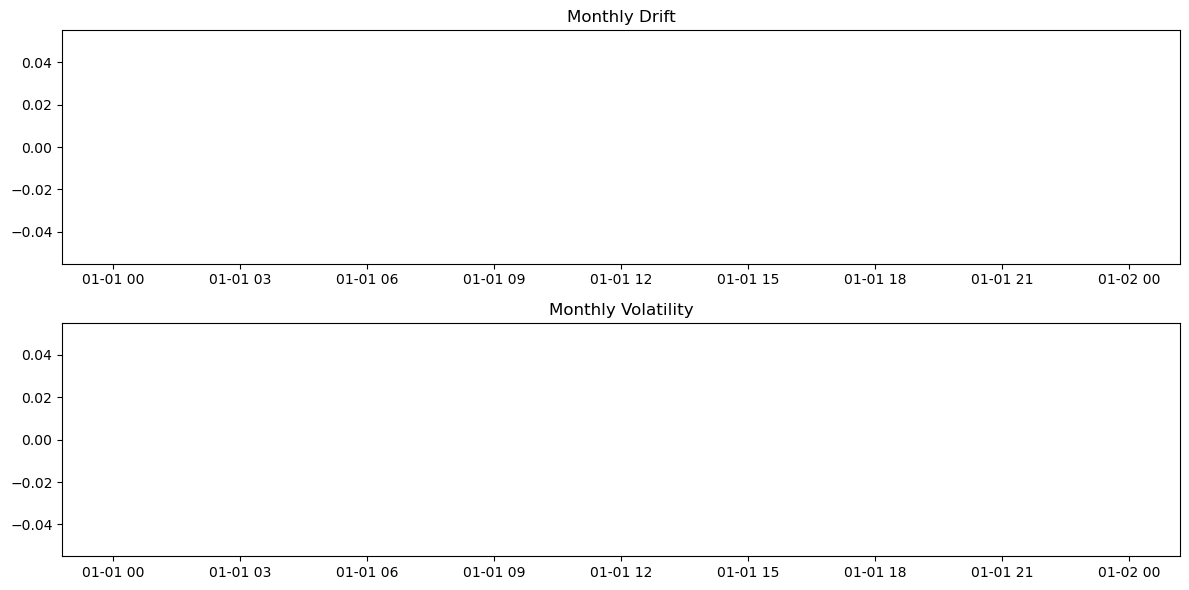

In [18]:
# 9. Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].plot(df.index, df['drift'], label='Drift')
axs[0].set_title("Monthly Drift")
axs[1].plot(df.index, df['volatility'], label='Volatility', color='orange')
axs[1].set_title("Monthly Volatility")
plt.tight_layout()
plt.show()
